# Beer Image Processing
#### Using cv2 and tensorflow (DNN and LSTM) 

## IMPORTING

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## PREPROCESSING

In [2]:
def get_beer_color(image):
    # Resize the image
    cropped_image = image[94:118, 114:138] # 24 x 24
    
    # Calculate the average color (BGR format)
    avg_color = cv2.mean(cropped_image)[:3]
    
    avg_color_rgb = avg_color[::-1]

    return avg_color_rgb

In [3]:
def get_sediment_image(image):
    # Resize the image
    image = image[212:252, 114:158] # 48 x 40
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    
    return image

In [4]:
def get_foam_image(image):
    # Resize the image
    image = image[14:96, 96:108] # 12 x 72
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
        
    return image

In [5]:
def normalize(image):
    # normalization for visualisation
    image_data_type = image.dtype

    if image_data_type == np.float32 or image_data_type == np.float64:
        # Normalize the float image to the range [0, 1]
        normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        # Convert the image to float and normalize it to the range [0, 1]
        normalized_image = image.astype(np.float32) / 255.0

    return normalized_image
    

In [6]:
def get_height(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Increase the brightness and contrast of the image
    image = cv2.convertScaleAbs(image, alpha=0.68, beta=14)

    # Convert the grayscale image back to RGB
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Convert the HSV image to grayscale
    gray = cv2.cvtColor(hsv, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create the mask
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Initialize min and max height variables
    min_height = None
    max_height = None

    # Iterate through the mask to find the highest and lowest points with continuous color
    for y in range(mask.shape[0]):
        # Check if the current row contains continuous color
        if np.all(mask[y, :] > 0):
            if min_height is None:
                min_height = y
            max_height = y

    # Calculate the height
    if min_height is not None and max_height is not None:
        height = max_height - min_height + 1
    else:
        height = 0

    return height


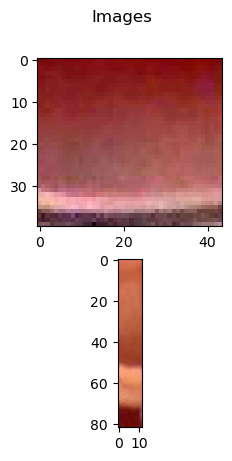

In [7]:
import glob
import os

# Get all .jpg image paths in a folder
folder_path = "../PythonArduino/PythonCode/images/"
image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))

# Sort image paths based on their names (assuming they are named with ascending timestamps)
image_paths.sort()

# Set corresponding timestamps for each image
timestamps = list(range(len(image_paths)))  # Using indices as timestamps, you can replace them with actual timestamps if available

fig, axs = plt.subplots(2)
fig.suptitle('Images')

data = []
for image_path, timestamp in zip(image_paths, timestamps):
      
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = image[224:480, 244:500] # 256 x 256
    
    # sediment
    sediment_image = get_sediment_image(image)
    sediment_image = normalize(sediment_image)
    axs[0].imshow(cv2.cvtColor(sediment_image, cv2.COLOR_BGR2RGB))
    sediment_height= get_height(sediment_image)
    
    # foam
    foam_image = get_foam_image(image)
    foam_image = normalize(foam_image)
    axs[1].imshow(cv2.cvtColor(foam_image, cv2.COLOR_BGR2RGB))
    foam_height= get_height(foam_image)
    
    # beer color
    beer_color = get_beer_color(image)
    
    data.append([timestamp, foam_height, beer_color, sediment_height])

# Convert data to a DataFrame
df = pd.DataFrame(data, columns=["timestamp", "foam_height", "beer_color", "sediment_height"])


In [8]:
def rgb_to_gray(rgb_tuple):
    R, G, B = rgb_tuple
    return 0.2989 * R + 0.5870 * G + 0.1140 * B

# Convert the beer_color column to grayscale
df["beer_color"] = df["beer_color"].apply(rgb_to_gray)

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Add fermentation progress to the DataFrame
fermentation_progress = [] # List of fermentation progress values corresponding to each image
for i in range(len(image_paths)):
    fermentation_progress.append(round((100 / (len(image_paths) - 1)) * i, 2))

df["fermentation_progress"] = fermentation_progress

In [15]:
df

,timestamp,foam_height,beer_color,sediment_height,fermentation_progress
0,0,82,44.471429,40,0.00
1,1,82,49.268021,40,0.23
2,2,82,52.345493,40,0.47
3,3,82,54.596969,40,0.70
4,4,82,55.655010,40,0.94
...,...,...,...,...,...
422,422,82,51.262901,40,99.06
423,423,82,51.250454,40,99.30
424,424,82,50.892673,40,99.53
425,425,82,50.871200,40,99.77


In [10]:
# Define input and output columns
input_columns = ["foam_height", "beer_color", "sediment_height"]
output_column = "fermentation_progress"

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df[input_columns])

# Prepare the output values
y = df[output_column].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape the input data for LSTM (samples, timesteps, features)
timesteps = 1
X_train = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])

In [11]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100


C:\Users\mark9\.conda\envs\ML-ENV\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


9/9 [==============================] - 3s 83ms/step - loss: 1350.3563 - mae: 31.7896 - val_loss: 5176.7461 - val_mae: 71.7976
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 1348.0427 - mae: 31.7525 - val_loss: 5171.4502 - val_mae: 71.7607
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 1345.1862 - mae: 31.7052 - val_loss: 5164.4990 - val_mae: 71.7122
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 1341.2819 - mae: 31.6418 - val_loss: 5155.0054 - val_mae: 71.6460
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 1335.8516 - mae: 31.5547 - val_loss: 5141.8706 - val_mae: 71.5543
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 1328.4705 - mae: 31.4307 - val_loss: 5123.1274 - val_mae: 71.4233
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 1317.4619 - mae: 31.2473 - val_loss: 5096.6621 - val_mae: 71.2379
Epoch 8/100
9/9 [==============================] - 0

Epoch 61/100
9/9 [==============================] - 0s 4ms/step - loss: 456.2952 - mae: 17.7406 - val_loss: 2622.2068 - val_mae: 50.9940
Epoch 62/100
9/9 [==============================] - 0s 4ms/step - loss: 460.7161 - mae: 17.8284 - val_loss: 2604.2983 - val_mae: 50.8181
Epoch 63/100
9/9 [==============================] - 0s 5ms/step - loss: 451.2696 - mae: 17.7101 - val_loss: 2586.4456 - val_mae: 50.6421
Epoch 64/100
9/9 [==============================] - 0s 4ms/step - loss: 451.8210 - mae: 17.6873 - val_loss: 2568.7031 - val_mae: 50.4666
Epoch 65/100
9/9 [==============================] - 0s 5ms/step - loss: 451.0261 - mae: 17.7118 - val_loss: 2552.0625 - val_mae: 50.3015
Epoch 66/100
9/9 [==============================] - 0s 4ms/step - loss: 451.2034 - mae: 17.7073 - val_loss: 2535.6553 - val_mae: 50.1381
Epoch 67/100
9/9 [==============================] - 0s 4ms/step - loss: 440.5061 - mae: 17.5470 - val_loss: 2519.0691 - val_mae: 49.9725
Epoch 68/100
9/9 [=======================

3/3 [==============================] - 0s 1ms/step - loss: 4110.3569 - mae: 63.8421
Test loss: 4110.35693359375, Test MAE: 63.84205627441406


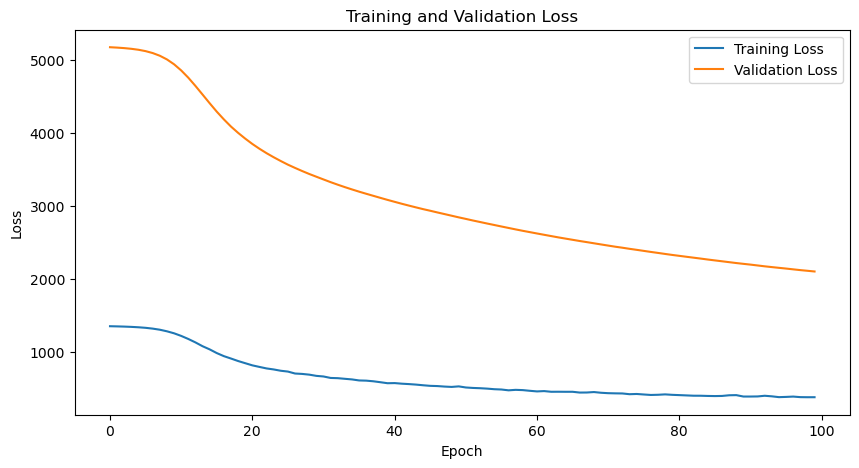

In [12]:
# Evaluate the model on the testing dataset
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_loss}, Test MAE: {test_mae}")

# Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()